Copyright 2021 Amazon.com and its affiliates; all rights reserved. This file is AWS Content and may not be duplicated or distributed without permission

# Demonstrate time travel with Amazon SageMaker Feature Store
This notebook provides a demo of performing both as-of time travel and row-level time travel using SageMaker Feature Store. It does this by using a simple set of utility functions that wrap the feature store API to keep it simple for a data scientist using Python.

### A few imports

#### To get pandas to save a file directly to s3
Need to tweak the Jupyter kernel environment to have latest versions and avoid incompatibility issues:
```
%pip install pandas --upgrade
%pip uninstall -y boto3
%pip uninstall -y botocore
%pip uninstall -y aiobotocore
%pip install boto3
%pip install s3fs
```

Stack overflow helped trace this down: [register lazy block issue](https://stackoverflow.com/questions/69994834/attributeerror-aioclientcreator-object-has-no-attribute-register-lazy-block), [pandas issue](https://github.com/pandas-dev/pandas/issues/45495), [pandas issue](https://stackoverflow.com/questions/63536517/permissionerror-while-using-pandas-to-csv-function).

In [ ]:
%pip install sagemaker --upgrade
%pip install pandas --upgrade
%pip uninstall -y boto3
%pip uninstall -y botocore
%pip uninstall -y aiobotocore
%pip install boto3 --upgrade
%pip install botocore --upgrade
%pip install s3fs

In [ ]:
from utilities.feature_store_helper import FeatureStore

from IPython.core.display import display, HTML, Markdown
import pandas as pd
import time
import json
from sklearn.ensemble import RandomForestClassifier

FG_NAME = 'fs-demo-2022-03-24'

fs = FeatureStore()

## Demonstrate as-of time travel

#### Time travel to get dataset as it looked on 2020-02-02 
Should see zipcode == 22222 for all records.

In [ ]:
fs.get_latest_offline_feature_values_as_of(FG_NAME, '2020-02-02T00:00:00Z')

#### Time travel to get dataset as it looked on 2020-02-01
Should see zipcode == 11111 for all records.

In [ ]:
fs.get_latest_offline_feature_values_as_of(FG_NAME, '2020-02-01T00:00:00Z')

## Demonstrate row-level time travel
Building accurate training datasets is difficult, as you may be training based on events of varying timestamps and features that were caculated at different intervals (some near real time, others daily or hourly). SageMaker's offline store makes it easy to to row-level time travel. Just specify a set of timestamps and identifiers, and let SageMaker gather the right versions of feature values for each. For more details, see this [blog post](https://aws.amazon.com/blogs/machine-learning/build-accurate-ml-training-datasets-using-point-in-time-queries-with-amazon-sagemaker-feature-store-and-apache-spark/).

#### Row-level time travel with SageMaker Feature Store
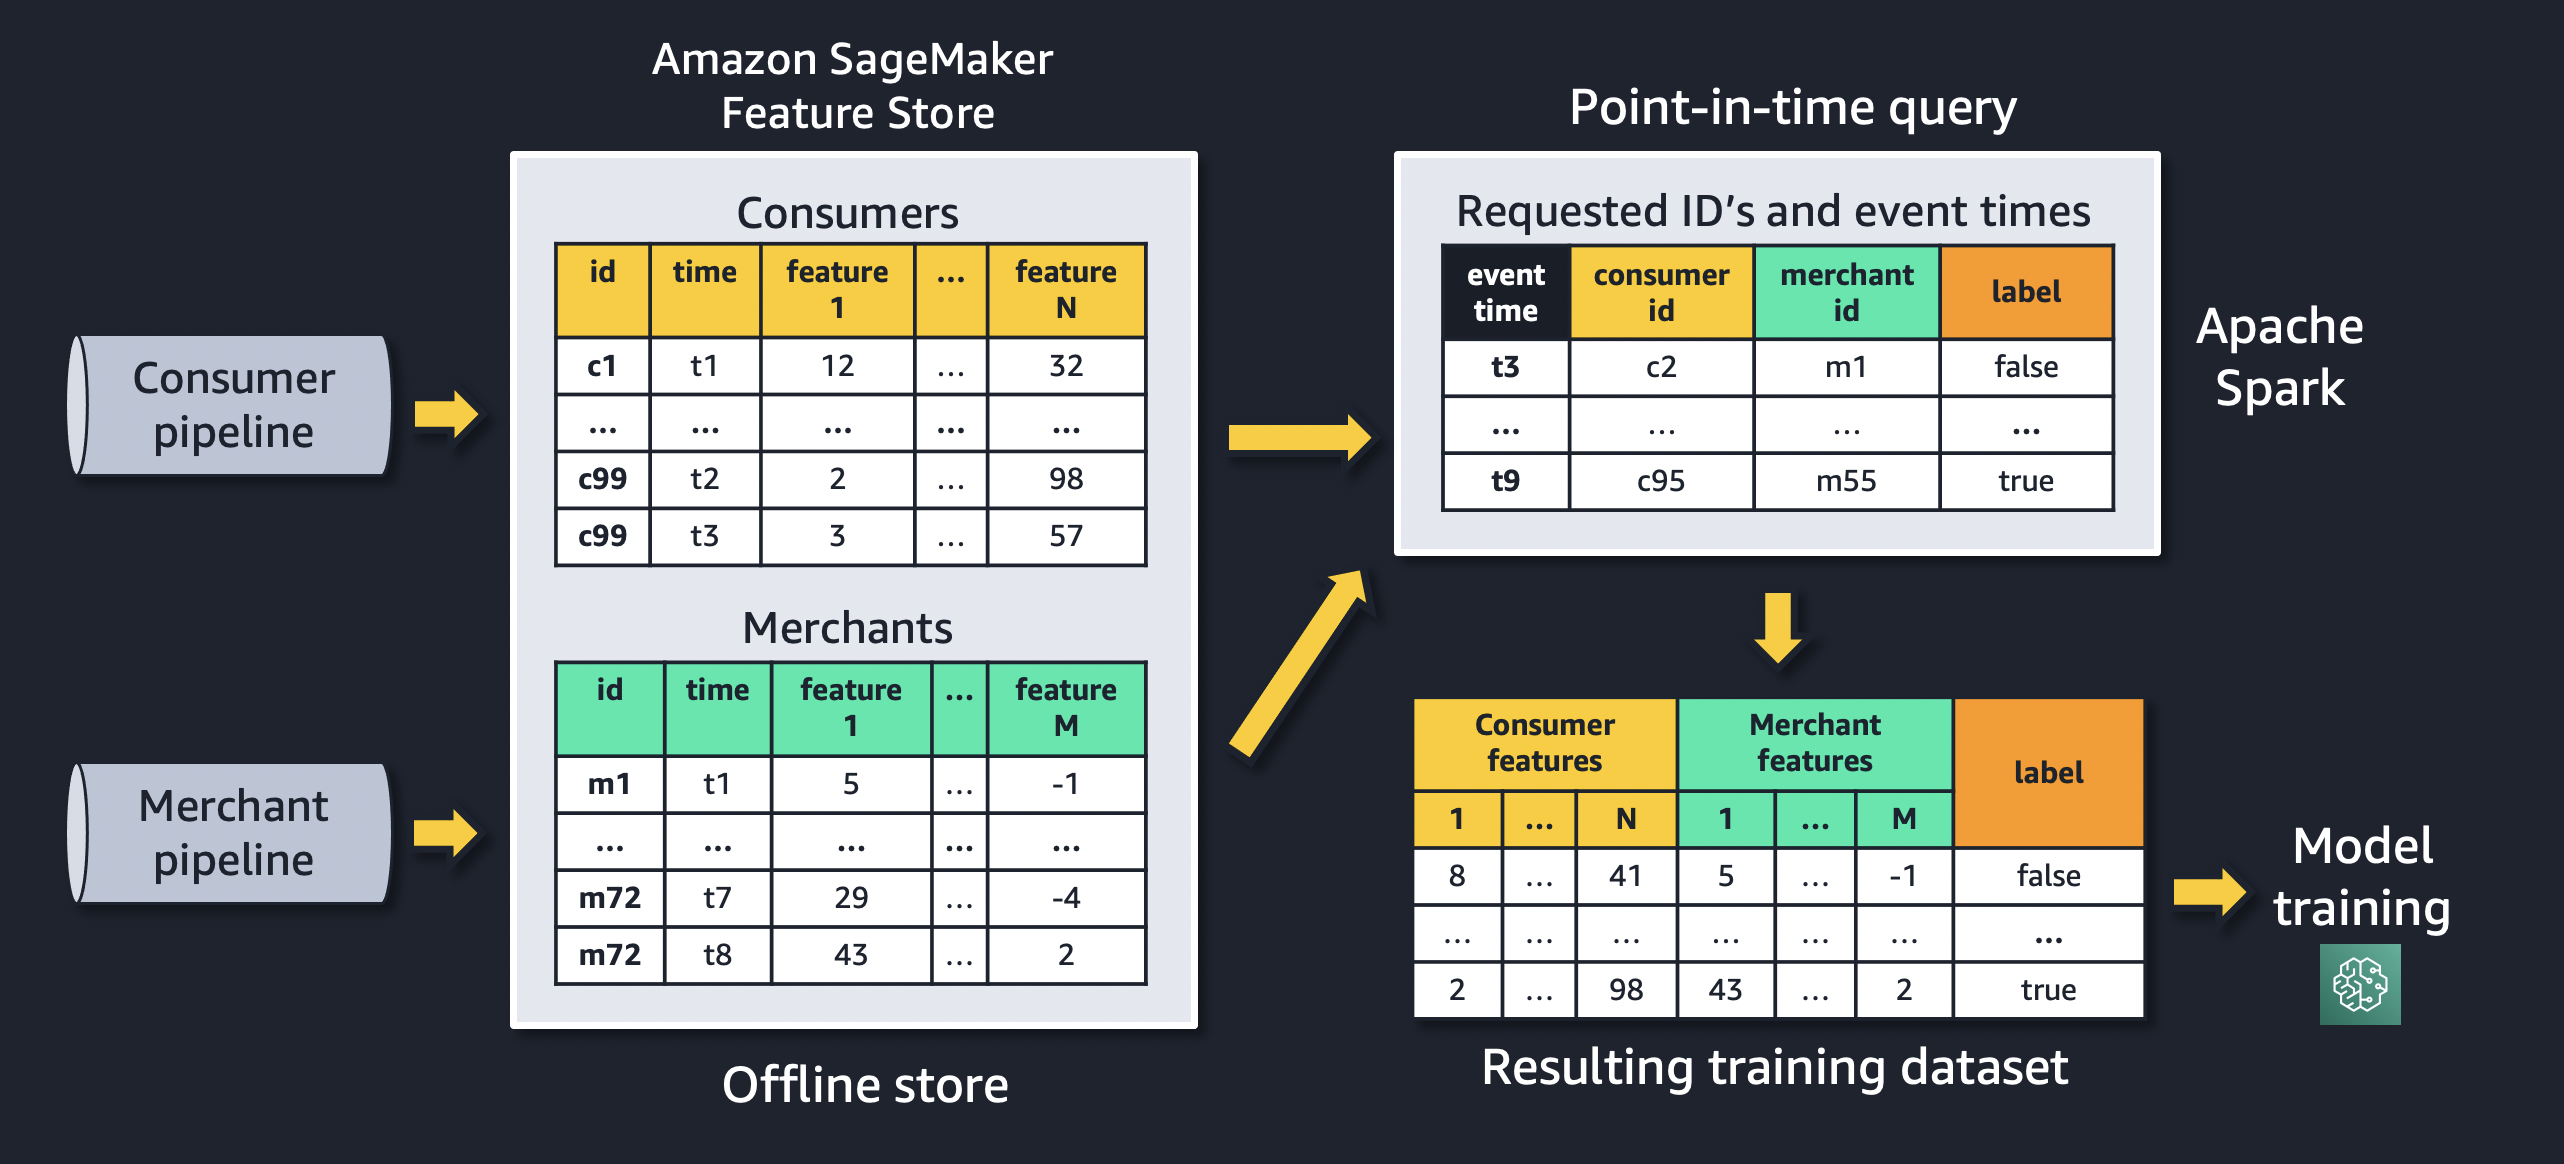

In this simple example, we specify a few identifiers and use a different timestamp for each.

In [ ]:
events = [['2020-02-01T08:30:00Z', 6],
          ['2020-02-02T10:15:30Z', 5],
          ['2020-02-03T13:20:59Z', 1],
          ['2021-01-01T00:00:00Z', 1]
         ]
df = pd.DataFrame(events, columns=['event_time', 'Id'])
df.head()

Now we get the accurate set of features for those events and identifiers.

In [ ]:
fs.get_features(df, timestamp_col='event_time', 
                   features=[f'{FG_NAME}:zipcode'],
               verbose=False)

In [ ]:
fs.get_features(df, 'event_time', 
                   features=[f'{FG_NAME}:ZipCode', 
                             'payments:avg_amount', 
                             'payments:avg_days_late',
                             f'{FG_NAME}:Churn',
                             'claims:*'
                            ])

In [ ]:
multi_id_events = [['2020-02-01T08:30:00Z', 6, 450],
          ['2020-02-02T10:15:30Z', 5, 5000],
          ['2020-02-03T13:20:59Z', 1, 1999],
          ['2021-01-01T00:00:00Z', 1, 2001]
         ]
multi_id_df = pd.DataFrame(multi_id_events, columns=['my_event_time', 'Id', 'HOUSE_ID'])
multi_id_df.head()

In [ ]:
fs.get_features(multi_id_df, 'my_event_time', 
                   features=[f'{FG_NAME}:ZipCode', 
                             'payments:avg_amount', 
                             'payments:avg_days_late'])

In [ ]:
import pandas as pd
multi_id_events = [
          ['2020-02-01T01:00:00Z', 1],
          ['2020-02-02T01:00:00Z', 1],
          ['2020-02-03T01:00:00Z', 1]
                  ]
multi_id_df = pd.DataFrame(multi_id_events, columns=['my_event_time', 'Id'])
fs.get_features(multi_id_df, 'my_event_time', 
                   features=[f'{FG_NAME}:ZipCode'])

In [ ]:
extended_order_events = [['2021-07-07T10:01:00Z', 'C1', 'O1', 'P1'],
          ['2021-07-07T10:02:00Z', 'C2', 'O2', 'P2'],
          ['2021-07-07T10:03:00Z', 'C3', 'O3', 'P3'],
          ['2021-07-07T10:04:00Z', 'C4', 'O4', 'P4']
         ]
extended_orders_df = pd.DataFrame(extended_order_events,
                                  columns=['my_event_time', 'customer_id', 'order_id', 'product_id'])
extended_orders_df.head()

In [ ]:
extended_order_events = []

for c in range(100):
    for o in range(10):
        for p in range(9):
            e = ['2021-07-07T10:01:00Z', f'C{c+1}', f'O{o+1}', f'P{p+1}']
            extended_order_events.append(e)

extended_orders_df = pd.DataFrame(extended_order_events,
                                  columns=['my_event_time', 'customer_id', 'order_id', 'product_id'])
print(f'Generated {extended_orders_df.shape[0]:,d} order events')
extended_orders_df.head()

%%time

Utils.get_features(extended_orders_df, 'my_event_time', 
                   features=['fscw-customers-08-10-15-54:is_married',
                             'fscw-orders-08-10-17-21-52:purchase_amount',
                             'fscw-products-08-10-15-54:*'], #category_chips_pretzels'],
                   parallel=False,
                   verbose=False)

#### Row-level time travel processing times for various numbers of events requested, across 3 feature groups with just a few features

NOTE: When moving beyond a few thousand events, you should use a larger instance type. For the tests below, I used ml.m5.4xlarge.

- 12 seconds to handle 100k events
- 14 seconds to handle 300k events 
- 17 seconds to handle 500k events 
- 25 seconds to handle 1M events 
- 1 minute and 3 seconds to handle 5M events 
- 1 minute and 56 seconds to handle 10M events 

#### Elapsed time when doing the table level time travel in series versus in parallel

There appears to be some thread safety issue that crops up periodically for large time travel requests. Still haven't been able to narrow it down and eliminate it. So, now offering a flag to run it in series. Takes longer of course, but still not bad.

NOTE: When moving beyond a few thousand events, you should use a larger instance type. For the tests ,I used ml.m5.4xlarge.

- 20s for 100k
- 41s for 1m
- 1min 41s for 5m
- 3min 7s for 10m